# GMNmeteorNet

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("tensorflow").addHandler(logging.NullHandler(logging.ERROR))
from keras import models
from keras import layers
from keras import losses
from keras import optimizers
import math
import pickle
import keras_tuner as kt

%matplotlib inline


print(tf.__version__)

2.14.0


## Image analysis

Number of images: 10344
Median: 87.0
Last non-outlier dimension: 195


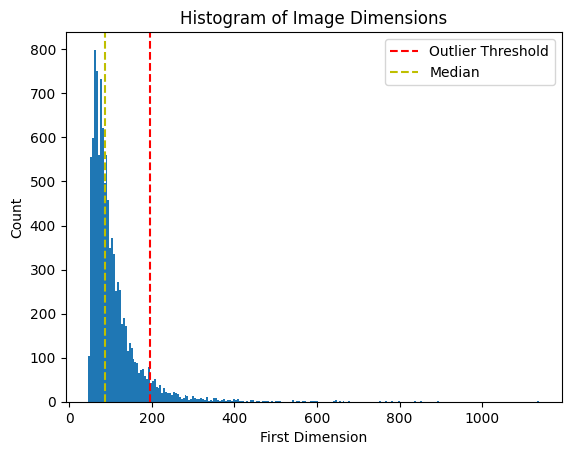

In [2]:
dataset = "mldataset/cropped"
dirs = [os.path.join(dataset, "Meteors"), os.path.join(dataset, "Artifacts")]
dimensions = []

for i in dirs:
    for j in os.listdir(i):

        img = os.path.join(i, j)

        if "synthesized" in img:

            for synth in os.listdir(img):
                img3 = os.path.join(img, synth)

                img2 = Image.open(img3)
                img_array = np.array(img2)
                dimensions.append(img_array.shape[0])
                img_array = np.expand_dims(img_array, axis=-1)
        else:
            img = Image.open(img)
            img_array = np.array(img)
            dimensions.append(img_array.shape[0])
            img_array = np.expand_dims(img_array, axis=-1)

print("Number of images:", len(dimensions))
median = np.median(dimensions)
print("Median:", np.median(dimensions))

q1 = np.percentile(dimensions, 25)
q3 = np.percentile(dimensions, 75)
iqr = q3 - q1
threshold = 1.5 * iqr
dimensions = np.sort(np.array(dimensions))
first_outlier = np.where((dimensions < q1 - threshold) | (dimensions > q3 + threshold))[
    0
]
last_non_outlier = dimensions[first_outlier[0] - 1]
print("Last non-outlier dimension:", dimensions[first_outlier[0] - 1])

plt.hist(dimensions, bins="auto")
plt.axvline(
    x=dimensions[first_outlier[0] - 1],
    color="r",
    linestyle="--",
    label="Outlier Threshold",
)
plt.axvline(x=median, color="y", linestyle="--", label="Median")
plt.legend()
plt.xlabel("First Dimension")
plt.ylabel("Count")
plt.title("Histogram of Image Dimensions")
plt.show()

In [3]:
confirmed_num = 0

confirmed_num += len(os.listdir(dirs[0]))
print("Number of meteor images:", confirmed_num)

rejected_images = []
rejected_num = 0

for filename in os.listdir(dirs[1]):
    if "synthesized" in filename:
        rejected_images += [
            os.path.join(dirs[1], filename, synth)
            for synth in os.listdir(os.path.join(dirs[1], filename))
        ]
    else:
        rejected_images.append(os.path.join(dirs[1], filename))

rejected_num = len(rejected_images)
print("Number of artifact images:", rejected_num)

Number of meteor images: 8500
Number of artifact images: 1844


## Image augmentation


In [22]:
data_augmentation = tf.keras.Sequential(
    [layers.RandomRotation(0.5), layers.RandomZoom((-0.5, 0.25))]
)
coeff = 0.4  # try playing with this, tested 1 and 0.4 values yield worse results than without augmentation

# balance classes by using data augmentation
while rejected_num < coeff * confirmed_num:
    random_image = tf.random.shuffle(rejected_images)[0]
    random_image_path = random_image.numpy().decode("utf-8")
    if "synthesized" in random_image_path:
        continue
    img = Image.open(random_image_path)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=-1)

    img_array = data_augmentation(img_array)

    augmented_img = Image.fromarray(np.squeeze(img_array).astype(np.uint8))
    os.makedirs(os.path.join(dirs[1], "synthesized"), exist_ok=True)
    # Save the image
    base_filename = os.path.basename(random_image_path)[:-4] + "_augmented"
    full_path = os.path.join(dirs[1], "synthesized", base_filename + ".png")
    i = 1

    # Loop until we find a filename that does not already exist
    while os.path.exists(full_path):
        # If a file with the same name already exists, append the counter to the filename
        full_path = os.path.join(
            dirs[1], "synthesized", base_filename + "_" + str(i) + ".png"
        )
        # Increment the counter
        i += 1
    augmented_img.save(full_path)
    rejected_num += 1
print("Classes balanced.")
print("Number of meteor images:", confirmed_num)
print("Number of artifact images:", rejected_num)

Classes balanced.
Number of meteor images: 8500
Number of artifact images: 3400


## Dataset

### Dataset creation


In [4]:
IMG_SIZE = int(np.median(dimensions))  # seems about right
IMG_SIZE = dimensions[first_outlier[0] - 1]
BATCH_SIZE = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset,
    label_mode="binary",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
)

class_names = train_ds.class_names

Found 10344 files belonging to 2 classes.
Using 8276 files for training.
Using 2068 files for validation.


### Dataset normalization


In [5]:
def standardize_image(image, label):
    """
    Linearly scales each image in image to have mean 0 and variance 1.
    """
    image = rescale(image)
    # image = tf.image.per_image_standardization(image)   model performs a bit worse with this on

    return image, label


AUTOTUNE = tf.data.AUTOTUNE

rescale = layers.Rescaling(1.0 / 255)

# standardize each image to have mean 0 and variance 1
train_ds = train_ds.map(standardize_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(standardize_image, num_parallel_calls=AUTOTUNE)

# buffered prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Dataset visualization

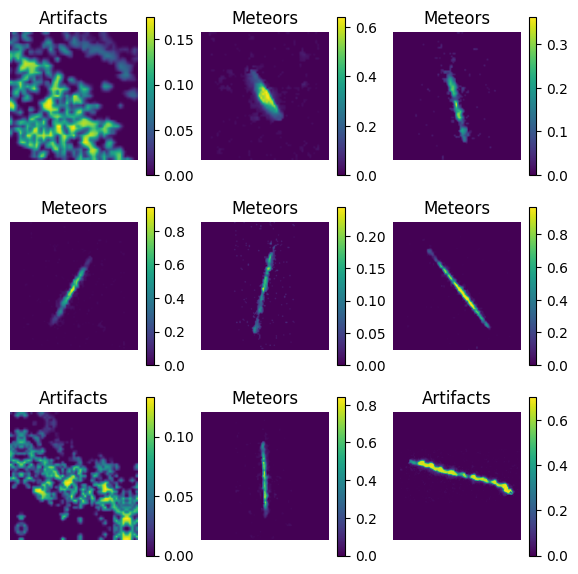

In [28]:
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("float32")

        plt.imshow(img)
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
        plt.colorbar()

## Model


### Hypermodel

In [5]:
# initial model from https://github.com/fiachraf/meteorml/blob/main/keras/training_scripts/CNN_script_20220325_1.py#L133


def model_builder(hp):
    model = tf.keras.models.Sequential()

    img_size = hp.Choice("img_size", [int(median), int(last_non_outlier)])
    model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(layers.Resizing(img_size, img_size))

    if hp.Boolean("normalize"):
        model.add(layers.Normalization())
    for i in range(hp.Int("num_conv_layers", 1, 3)):

        model.add(
            layers.Conv2D(
                hp.Int(
                    f"conv_filter_num_{i}",
                    min_value=2 + 3 * i,
                    max_value=10 + 5 * i,
                    step=2,
                ),
                hp.Int(f"conv_kernel_{i}", 3, 10),
                activation="relu",
            )
        )
        if i == 0:
            model.add(layers.Dropout(rate=0.2))
            model.add(
                layers.MaxPooling2D(
                    hp.Int(f"max_kernel_{i}", 2, 6),
                    strides=hp.Int(f"max_stride_{i}", 1, 5),
                )
            )

    model.add(layers.Flatten())

    if hp.Boolean("2nd_dense"):
        model.add(
            layers.Dense(
                units=hp.Int("dense_units", min_value=16, max_value=128, step=16),
                activation="relu",
            )
        )
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        loss=(losses.BinaryCrossentropy()),
        optimizer=optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-3, 1e-4])
        ),
        metrics=[
            tf.keras.metrics.F1Score(name="f1", threshold=0.5),
            tf.keras.metrics.Recall(name="recall", thresholds=0.5),
            tf.keras.metrics.Precision(name="precision", thresholds=0.5),
            # prioritize recall over precision
            tf.keras.metrics.FBetaScore(name="fbeta2", beta=2.0, threshold=0.5),
        ],
    )

    return model

### Tuning

In [24]:
tuner = kt.Hyperband(
    model_builder,
    objective=kt.Objective("val_fbeta2", direction="max"),
    max_epochs=22,
    factor=3,
    directory="keras_tuner",
    project_name="GMNmeteorNet",
    overwrite=True,
    hyperband_iterations=2,
)
"""
tuner2 = kt.BayesianOptimization(
    model_builder,
    objective=kt.Objective("val_fbeta2", direction="max"),
    max_trials=20,
    directory="keras_tuner",
    project_name="GMNmeteorNet",
    overwrite=True,
)
"""
# tuner.search_space_summary()

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)

In [25]:
tuner.search(
    train_ds,
    validation_data=val_ds,
    callbacks=[stop_early, tf.keras.callbacks.TensorBoard("/tmp/tb_logs")],
)

Trial 60 Complete [00h 00m 29s]
val_fbeta2: 0.9914649724960327

Best val_fbeta2 So Far: 0.9932107329368591
Total elapsed time: 00h 18m 12s


In [27]:
tuner.results_summary()

Results summary
Results in keras_tuner/GMNmeteorNet
Showing 10 best trials
Objective(name="val_fbeta2", direction="max")

Trial 0056 summary
Hyperparameters:
img_size: 87
normalize: True
num_conv_layers: 2
conv_filter_num_0: 6
conv_kernel_0: 5
max_kernel_0: 2
max_stride_0: 3
2nd_dense: True
learning_rate: 0.001
conv_filter_num_1: 9
conv_kernel_1: 8
conv_filter_num_2: 8
conv_kernel_2: 6
dense_units: 96
tuner/epochs: 22
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9932107329368591

Trial 0002 summary
Hyperparameters:
img_size: 195
normalize: True
num_conv_layers: 2
conv_filter_num_0: 10
conv_kernel_0: 3
max_kernel_0: 2
max_stride_0: 3
2nd_dense: True
learning_rate: 0.001
conv_filter_num_1: 15
conv_kernel_1: 9
conv_filter_num_2: 20
conv_kernel_2: 5
dense_units: 112
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.9930986166000366

Trial 0044 summary
Hyperparameters:
img_size: 195
normalize: True
num_conv_layers: 1
conv_filter_num_0: 10
con

In [28]:
best_hp = tuner.get_best_hyperparameters()[0]
models_list = tuner.get_best_models(num_models=2)
for i in models_list:
    i.summary()

print(best_hp.values)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 87, 87, 1)         0         
                                                                 
 normalization (Normalizati  (None, 87, 87, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 83, 83, 6)         156       
                                                                 
 dropout (Dropout)           (None, 83, 83, 6)         0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 9)         3

In [13]:
%load_ext tensorboard

%tensorboard --logdir /tmp/tb_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 336163), started 0:04:49 ago. (Use '!kill 336163' to kill it.)

In [29]:
# Get the optimal hyperparameters
model_name = "CNN_20240630_1"
model = tuner.hypermodel.build(best_hp)
model._name = model_name
model.summary()

Model: "CNN_20240630_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 87, 87, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 87, 87, 1)         3         
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 83, 83, 6)         156       
                                                                 
 dropout_1 (Dropout)         (None, 83, 83, 6)         0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 9)      

In [30]:
# saving model architecture
json_config = model.to_json()
with open(f"models/{model_name}_config.json", "w") as json_file:
    json_file.write(json_config)

### Model architecture loading

In [37]:
with open("models/CNN_20240618_3_config.json", "r") as json_file:
    json_config = json_file.read()
model = models.model_from_json(json_config)
model.compile(
    loss=(losses.BinaryCrossentropy()),
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=[
        tf.keras.metrics.F1Score(name="f1", threshold=0.5),
        tf.keras.metrics.Recall(name="recall", thresholds=0.5),
        tf.keras.metrics.Precision(name="precision", thresholds=0.5),
        # prioritize recall over precision
        tf.keras.metrics.FBetaScore(name="fbeta2", beta=2.0, threshold=0.5),
    ],
)
model.summary()

Model: "CNN_20240618_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 87, 87, 1)         0         
                                                                 
 normalization (Normalizati  (None, 87, 87, 1)         3         
 on)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 8)         80        
                                                                 
 dropout_1 (Dropout)         (None, 85, 85, 8)         0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 5)      

### Training

In [38]:
EPOCHS = 20
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/20


259/259 [==============================] - 4s 9ms/step - loss: 0.5469 - f1: 0.9008 - recall: 0.9618 - precision: 0.8471 - fbeta2: 0.9364 - val_loss: 0.3378 - val_f1: 0.9225 - val_recall: 1.0000 - val_precision: 0.8561 - val_fbeta2: 0.9675
Epoch 2/20
259/259 [==============================] - 2s 8ms/step - loss: 0.2050 - f1: 0.9597 - recall: 0.9978 - precision: 0.9245 - fbeta2: 0.9822 - val_loss: 0.1720 - val_f1: 0.9670 - val_recall: 0.9976 - val_precision: 0.9381 - val_fbeta2: 0.9851
Epoch 3/20
259/259 [==============================] - 2s 8ms/step - loss: 0.1407 - f1: 0.9742 - recall: 0.9940 - precision: 0.9552 - fbeta2: 0.9860 - val_loss: 0.1428 - val_f1: 0.9722 - val_recall: 0.9976 - val_precision: 0.9481 - val_fbeta2: 0.9873
Epoch 4/20
259/259 [==============================] - 2s 9ms/step - loss: 0.1234 - f1: 0.9774 - recall: 0.9950 - precision: 0.9604 - fbeta2: 0.9879 - val_loss: 0.1310 - val_f1: 0.9739 - val_recall: 0.9976 - val_precision: 0.9513 - val_fbeta2: 0.9880
Epoch 5/20


In [34]:
model.save(f"models/{model_name}.keras")

with open(f"models/{model_name}_history.pkl", "wb") as f:
    pickle.dump(history, f)

### Loading model

In [60]:
model = models.load_model("models/CNN_20240618_3.keras")
model.summary()

Model: "CNN_20240618_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 87, 87, 1)         0         
                                                                 
 normalization (Normalizati  (None, 87, 87, 1)         3         
 on)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 8)         80        
                                                                 
 dropout_1 (Dropout)         (None, 85, 85, 8)         0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 5)      

In [69]:
with open("models/CNN_20240618_3_history.pkl", "rb") as f:
    history = pickle.load(f)

### Model Evaluation

In [17]:
# Compile the model
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Evaluate the model on the validation dataset
results = model.evaluate(val_ds)
print
# Print the evaluation results
print("Loss:", results[0])
print("Accuracy:", results[1])

107/107 [==============================] - 1s 5ms/step - loss: 0.1379 - f1: 0.9676 - recall: 0.9905
Loss: 0.1378592550754547
Accuracy: [0.9675926]


## Result analysis

### Plotting results

Validation F1-Score: [0.98375875]


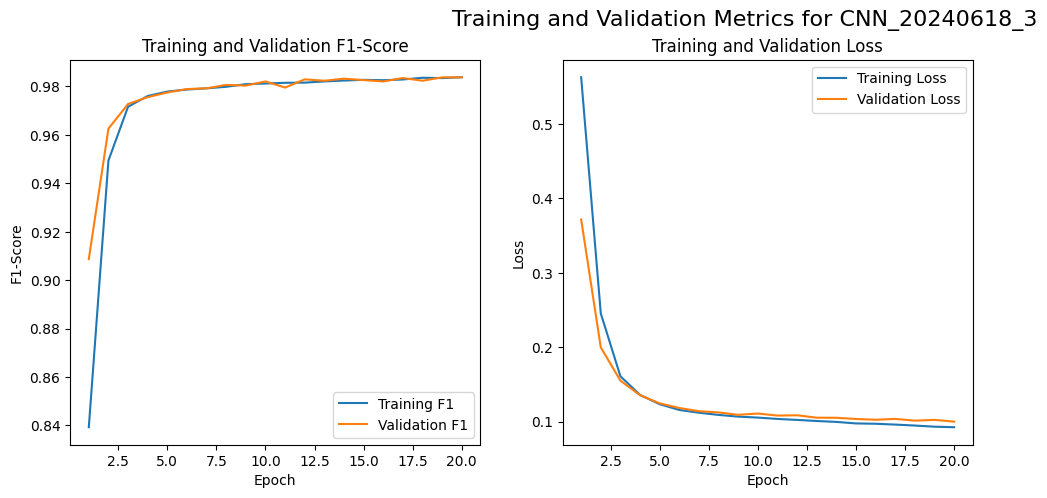

In [62]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
f1 = history.history["f1"]
val_f1 = history.history["val_f1"]
fbeta2 = history.history["fbeta2"]
val_fbeta2 = history.history["val_fbeta2"]


print("Validation F1-Score:", val_f1[-1])


epoch_range = range(1, len(loss) + 1)
plt.figure(figsize=(18, 5))
plt.suptitle(
    f"Training and Validation Metrics for {model._name}",
    fontsize=16,
)
# F1-Score Plot
plt.subplot(1, 3, 1)
plt.plot(epoch_range, f1, label="Training F1")
plt.plot(epoch_range, val_f1, label="Validation F1")
plt.title("Training and Validation F1-Score")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.legend()

# Loss Plot
plt.subplot(1, 3, 2)
plt.plot(epoch_range, loss, label="Training Loss")
plt.plot(epoch_range, val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Recall Plot
plt.subplot(1, 3, 3)
plt.plot(epoch_range, fbeta2, label="Training Fbeta")
plt.plot(epoch_range, val_fbeta2, label="Validation Fbeta")
plt.title("Training and Validation Fbeta-Score")
plt.xlabel("Epoch")
plt.ylabel("Fbeta-Score")
plt.legend()

plt.savefig(f"models/{model._name}_results.png")
plt.show()

### Confusion matrix

In [40]:
Y_pred = model.predict(val_ds, verbose=0)
Y_pred_labels = np.squeeze(np.round(Y_pred))

Y_true = np.squeeze(np.concatenate([y for x, y in val_ds], axis=0))

confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_labels, num_classes=2).numpy()
print("True positives:", confusion_mtx[1][1])
print("True negatives:", confusion_mtx[0][0])
print("False positives:", confusion_mtx[0][1])
print("False negatives:", confusion_mtx[1][0])

precision = confusion_mtx[1][1] / (confusion_mtx[1][1] + confusion_mtx[0][1])
recall = confusion_mtx[1][1] / (confusion_mtx[1][1] + confusion_mtx[1][0])
print("\nPrecision:", precision)
print("Recall:", recall)
false_negatives = confusion_mtx[1][0]
false_positives = confusion_mtx[0][1]

True positives: 1697
True negatives: 314
False positives: 52
False negatives: 5

Precision: 0.9702687249857062
Recall: 0.9970622796709753


False negatives: 6
False positives: 50


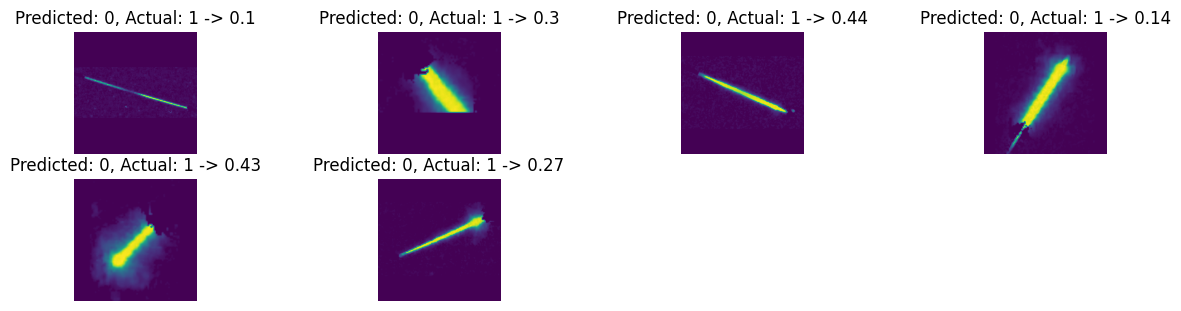

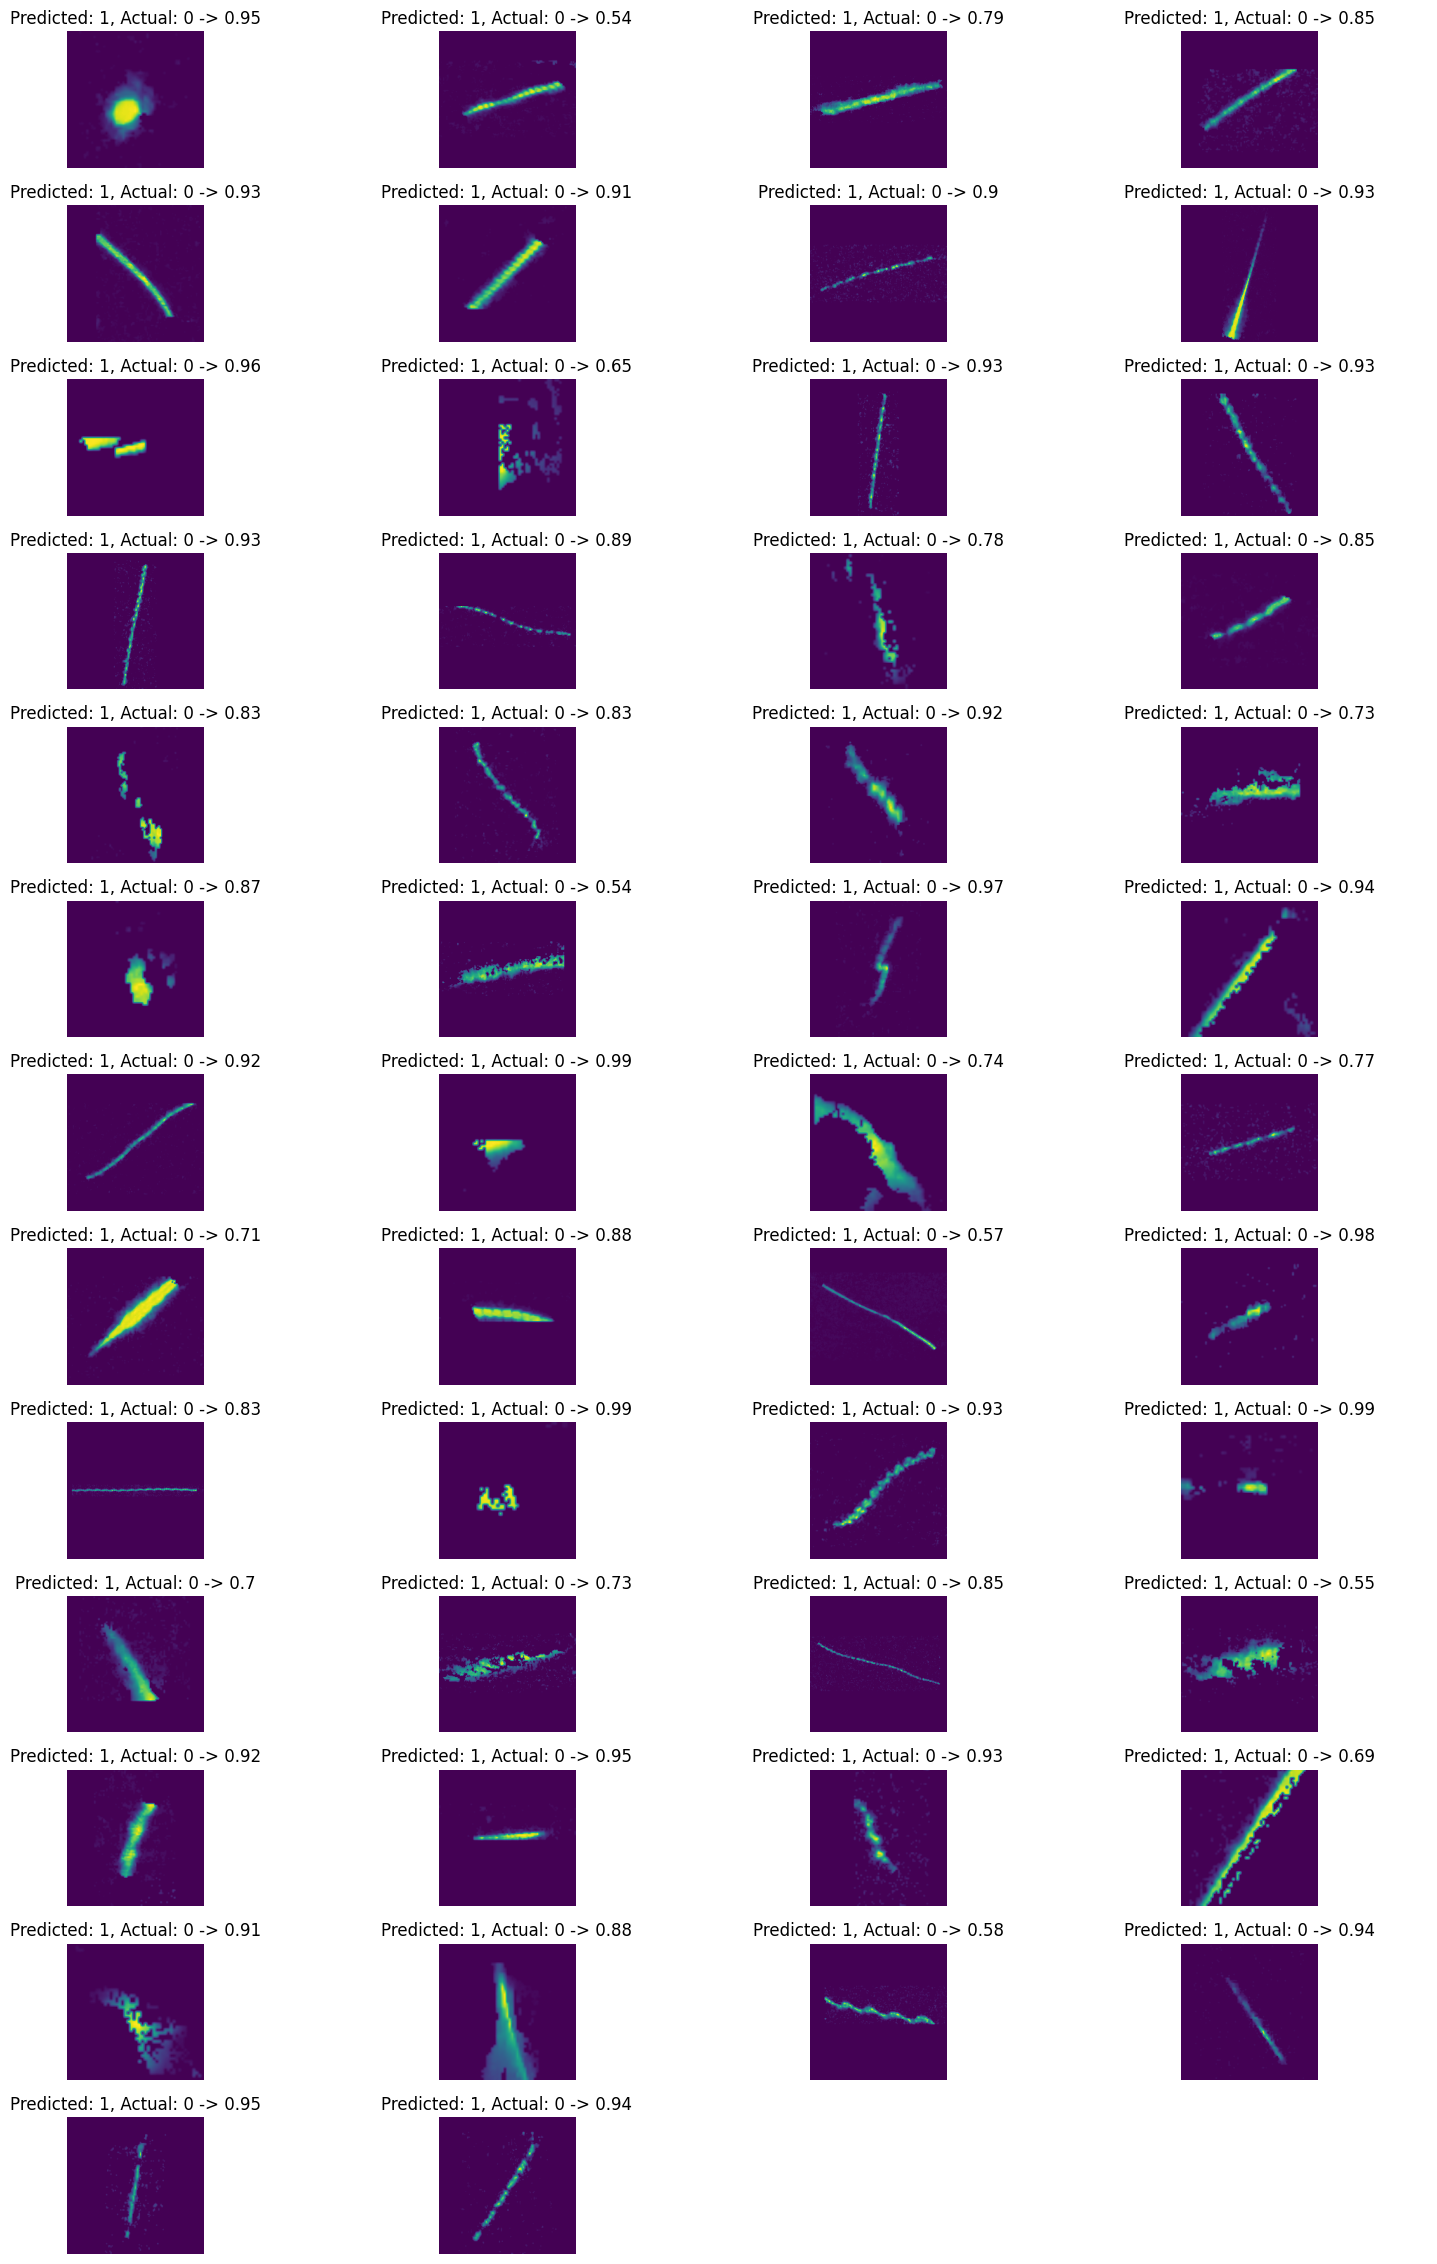

In [22]:
columns_num = 4
fig, axes = plt.subplots(
    math.ceil(false_negatives / columns_num),
    columns_num,
    figsize=(15, 7 * math.ceil(false_negatives / columns_num) / 4),
)
fig2, axes2 = plt.subplots(
    math.ceil(false_positives / columns_num),
    columns_num,
    figsize=(15, 7 * math.ceil(false_positives / columns_num) / 4),
)
for ax in axes.flatten():
    ax.axis("off")
for ax in axes2.flatten():
    ax.axis("off")

plt.subplots_adjust(hspace=0.05)
counter = 0
counter2 = 0
for i, (img, true_label) in enumerate(val_ds.unbatch()):
    if Y_pred_labels[i] == 0 and true_label == 1:

        img2 = img[np.newaxis, ...]
        # print(img2.shape)
        prediction = model.predict(img2, verbose=0)
        row = counter // columns_num
        col = counter % columns_num
        counter += 1
        prediction_confidence = str(round(prediction[0][0], 2))

        if math.ceil(false_negatives / columns_num) > 1:
            axes[row, col].imshow(img)
            axes[row, col].set_title(
                f"Predicted: {int(Y_pred_labels[i])}, Actual: {int(true_label)} -> {prediction_confidence}"
            )
        else:
            axes[col].imshow(img)
            axes[col].set_title(
                f"Predicted: {int(Y_pred_labels[i])}, Actual: {int(true_label)} -> {prediction_confidence}"
            )

    elif Y_pred_labels[i] == 1 and true_label == 0:

        img2 = img[np.newaxis, ...]
        # print(img2.shape)
        prediction = model.predict(img2, verbose=0)
        row = counter2 // columns_num
        col = counter2 % columns_num
        counter2 += 1
        axes2[row, col].imshow(img)
        prediction_confidence = str(round(prediction[0][0], 2))
        axes2[row, col].set_title(
            f"Predicted: {int(Y_pred_labels[i])}, Actual: {int(true_label)} -> {prediction_confidence}"
        )
print("False negatives:", counter)
print("False positives:", counter2)
plt.tight_layout()
plt.show()

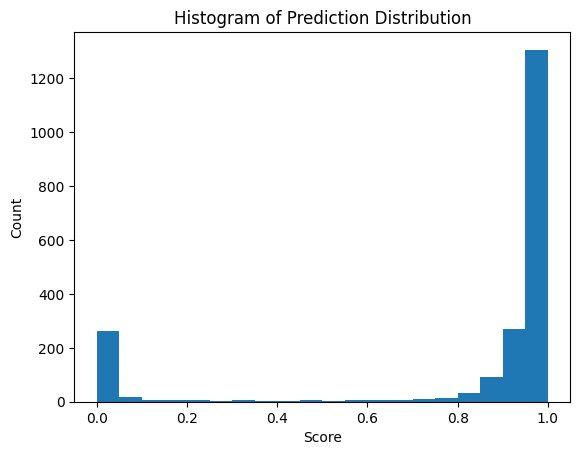

In [40]:
plt.hist(Y_pred, bins=20)

plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Histogram of Prediction Distribution")
plt.show()

### Predicting single example

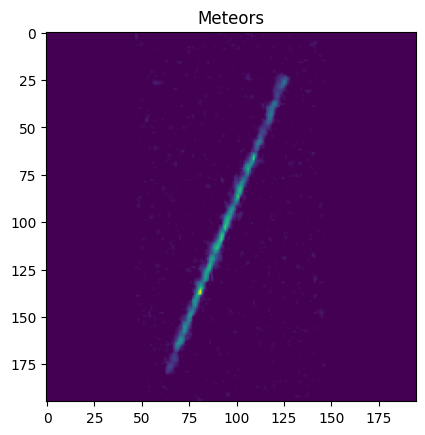

1/1 [==============================] - 0s 344ms/step
Prediction:           0.9727458357810974 - > True


In [54]:
x = val_ds.shuffle(1000).take(1)
for img, lab in x:
    plt.figure()
    plt.imshow(img[0].numpy().astype("float32"))
    plt.title(f"{class_names[int(lab[0])]}")
    plt.show()
    img = img[0][np.newaxis, ...]
    prediction = model.predict(img)
    print(
        f"Prediction: \
          {prediction[0][0]} - > {class_names[int(np.round(prediction[0][0]))] == class_names[int(lab[0])]}"
    )
    break

## Testing Fiachra's model


In [29]:
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(8, (5, 5), activation="relu", input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((5, 5)))
# model.add(layers.Conv2D(64, (3,3), activation="relu"))
# model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Conv2D(64, (3,3), activation="relu"))
# model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 8)         208       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 8)           0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                3216      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3441 (13.44 KB)
Trainable params: 3441 (13.44 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [57]:
interpreter = tf.lite.Interpreter(model_path="meteorml32.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on input data.
input_shape = input_details[0]["shape"]
correct_predictions = 0
total_predictions = 0

resize_32 = layers.Resizing(32, 32)
rescale = layers.Rescaling(1.0 / 255)
# Iterate over each batch
sample = val_ds.shuffle(1000).take(10)
for image_batch, label_batch in sample:
    total_predictions += image_batch.shape[0]

    for i in range(image_batch.shape[0]):
        img = resize_32(image_batch[i])
        # img=rescale(img)

        input_data = np.expand_dims(img, axis=0)
        interpreter.set_tensor(input_details[0]["index"], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]["index"])
        # print(output_data)
        # print(np.round(output_data)[0][0])

        # Get the highest scoring class
        prediction = int(np.round(output_data)[0][0])
        # print(prediction)
        # break
        correct_predictions += prediction == label_batch[i].numpy()


print("Correct predictions:", correct_predictions[0], "/", total_predictions)
# Calculate accuracy
accuracy = correct_predictions / total_predictions
print("Test accuracy:", accuracy)

Correct predictions: 278 / 320
Test accuracy: [0.86875]
